In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os

from utils import *

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "layer_norm" 
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)
take_x_seeds = 5
use_se = True

In [16]:
h_dim=1024 
exp_names = [
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln",
]

exp_names_mapping = {
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_": "Depth 4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_": "Depth 3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_": "Depth 2",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln": "Depth 4 LN",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln": "Depth 3 LN",
    # "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln": "Depth 2 LN",
}




# h_dim=512
# exp_names = [
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_",
# ]
# 
# exp_names_mapping = {
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_": "Depth 4",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_": "Depth 3",
#     "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_": "Depth 2",
# }

h_dim=256
exp_names = [
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2",
]

exp_names_mapping = {
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4": "Depth 4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3": "Depth 3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2": "Depth 2",
}



In [17]:
env_title_mapping = {
    "ant_ball": "Ant Soccer",
    "ant": "Ant",
    "ant_u_maze": "Ant U-Maze",
}
metric_to_metric_label_dict = {
    "eval/episode_success": "Time near goal",
    "eval/episode_success_any": "Success rate",
}

# Results for all envs

In [18]:
metrics_ = ["eval/episode_success_any", "eval/episode_success"]
single_env=False


In [19]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [20]:
len(runs)

45

Depth 4, Ant Soccer
(5, 1, 50)
Depth 3, Ant Soccer
(5, 1, 50)
Depth 2, Ant Soccer
(5, 1, 50)
Depth 4, Ant
(5, 1, 50)
Depth 3, Ant
(5, 1, 50)
Depth 2, Ant
(5, 1, 50)
Depth 4, Ant U-Maze
(5, 1, 50)
Depth 3, Ant U-Maze
(5, 1, 50)
Depth 2, Ant U-Maze
(5, 1, 50)
Depth 4, Ant Soccer
(5, 1, 50)
Depth 3, Ant Soccer
(5, 1, 50)
Depth 2, Ant Soccer
(5, 1, 50)
Depth 4, Ant
(5, 1, 50)
Depth 3, Ant
(5, 1, 50)
Depth 2, Ant
(5, 1, 50)
Depth 4, Ant U-Maze
(5, 1, 50)
Depth 3, Ant U-Maze
(5, 1, 50)
Depth 2, Ant U-Maze
(5, 1, 50)


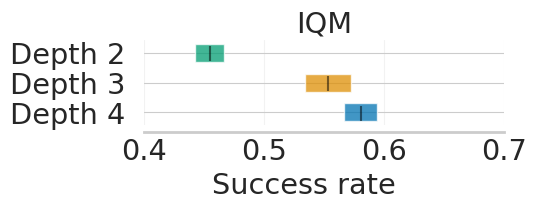

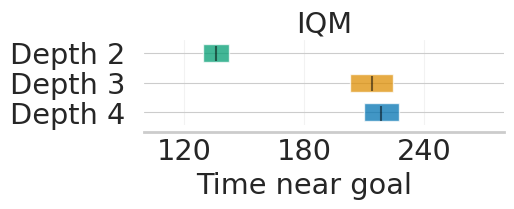

In [21]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
    )
    
    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 
    
    data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
    
    
    aggregate_func = lambda x: np.array(
    [
        # metrics.aggregate_median(x),
        metrics.aggregate_iqm(x),
        # metrics.aggregate_mean(x),
    ]
    )
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        data_flattened, aggregate_func, reps=500
    )
    # Change to se
    if use_se:
        for key, elem in aggregate_scores.items():
            se = (aggregate_score_cis[key][1]-aggregate_score_cis[key][0])/2/1.96 
            aggregate_score_cis[key] = np.concatenate(((elem-se)[None, :], (elem+se)[None,:]), axis=0)

    
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        # metric_names=["Median", "IQM", "Mean"],
        metric_names=["IQM"],
        algorithms=list(data.keys()),
        xlabel=f"{metric_label}",
        grid_alpha=0.4,
        max_ticks=3,
        subfigure_width=4,
        xlabel_y_coordinate=-0.5,
    )
    plt.subplots_adjust(wspace=0.2, left=0.0)
    
    if isinstance(axes, matplotlib.axes._axes.Axes):
        axes = [axes]
        
    for ax in axes:
        if metric_label == "Success rate":
            ax.set_xlim((0.4, 0.7))
        else:
            ax.set_xlim((100, 280))
    
    plt.savefig(
        os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_all_{h_dim}.pdf"), bbox_inches="tight"
    )
        
    

# Aggregated Success Rate and Proximity 

In [22]:
h_dim=1024 
exp_names = [
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln",
]

exp_names_mapping = {
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_": "Depth 4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_": "Depth 3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_": "Depth 2",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln": "Depth 4 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln": "Depth 3 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln": "Depth 2 LN",
}

filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)


Depth 4, Ant Soccer
(5, 1, 50)
Depth 3, Ant Soccer
(5, 1, 50)
Depth 2, Ant Soccer
(5, 1, 50)
Depth 4 LN, Ant Soccer
(5, 1, 50)
Depth 3 LN, Ant Soccer
(5, 1, 50)
Depth 2 LN, Ant Soccer
(5, 1, 50)
Depth 4, Ant
(5, 1, 50)
Depth 3, Ant
(5, 1, 50)
Depth 2, Ant
(5, 1, 50)
Depth 4 LN, Ant
(5, 1, 50)
Depth 3 LN, Ant
(5, 1, 50)
Depth 2 LN, Ant
(5, 1, 50)
Depth 4, Ant U-Maze
(5, 1, 50)
Depth 3, Ant U-Maze
(5, 1, 50)
Depth 2, Ant U-Maze
(5, 1, 50)
Depth 4 LN, Ant U-Maze
(5, 1, 50)
Depth 3 LN, Ant U-Maze
(5, 1, 50)
Depth 2 LN, Ant U-Maze
(5, 1, 50)
Depth 4, Ant Soccer
(5, 1, 50)
Depth 3, Ant Soccer
(5, 1, 50)
Depth 2, Ant Soccer
(5, 1, 50)
Depth 4 LN, Ant Soccer
(5, 1, 50)
Depth 3 LN, Ant Soccer
(5, 1, 50)
Depth 2 LN, Ant Soccer
(5, 1, 50)
Depth 4, Ant
(5, 1, 50)
Depth 3, Ant
(5, 1, 50)
Depth 2, Ant
(5, 1, 50)
Depth 4 LN, Ant
(5, 1, 50)
Depth 3 LN, Ant
(5, 1, 50)
Depth 2 LN, Ant
(5, 1, 50)
Depth 4, Ant U-Maze
(5, 1, 50)
Depth 3, Ant U-Maze
(5, 1, 50)
Depth 2, Ant U-Maze
(5, 1, 50)
Depth 4 LN, Ant 

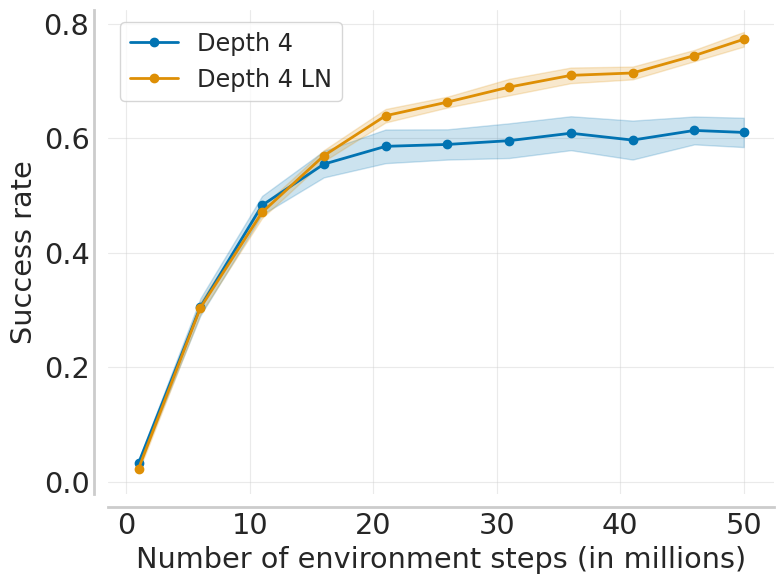

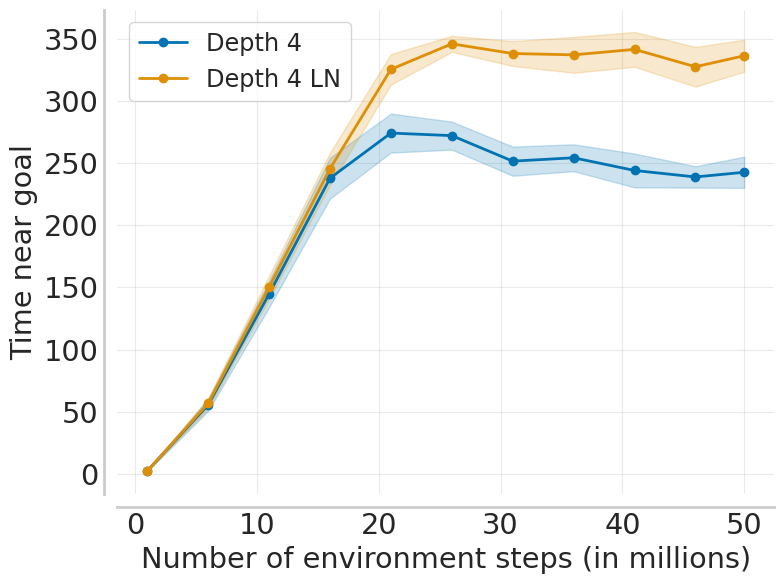

In [23]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
    )
    data = {key:elem for key, elem in data.items() if "Depth 4" in key}
    
    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 
    
    data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}
    
    frames = np.arange(0, 55, 5)
    frames[-1] -=1
    ale_frames_scores_dict = {
        algorithm: score[:, :, frames]
        for algorithm, score in data.items()
    }
    iqm = lambda scores: np.array(
        [metrics.aggregate_iqm(scores[..., frame]) for frame in range(scores.shape[-1])]
    )
    iqm_scores, iqm_cis = rly.get_interval_estimates(
        ale_frames_scores_dict, iqm, reps=500
    )
    
    # Change to se
    if use_se:
        for key, elem in iqm_scores.items():
            se = np.apply_along_axis(lambda x: x[1]-x[0], axis=0, arr=iqm_cis[key])/2/1.96 
            iqm_cis[key] = np.concatenate(((elem-se)[None, :], (elem+se)[None,:]), axis=0)
            
    plot_utils.plot_sample_efficiency_curve(
        frames + 1,
        iqm_scores,
        iqm_cis,
        algorithms=list(data.keys()),
        xlabel=r"Number of environment steps (in millions)",
        ylabel=metric_label,
        # legend=plot_legend,
        legend=True,
        grid_alpha=0.4,
        figsize=(8, 6)
    )
    # plt.title(f"{env_title_mapping[env]}", fontsize="xx-large")
    # plt.title(f"Success Rate", fontsize="xx-large")
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_all_efficiency.pdf"))

# All

In [24]:
exp_names = [
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln",
    
]

exp_names_mapping = {
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4": "Depth 4 #256",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3": "Depth 3 #256",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2": "Depth 2 #256",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4--use_ln": "Depth 4 #256 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3--use_ln": "Depth 3 #256 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2--use_ln": "Depth 2 #256 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_": "Depth 4 #512",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_": "Depth 3 #512",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_": "Depth 2 #512",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_512_--use_ln": "Depth 4 #512 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_512_--use_ln": "Depth 3 #512 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_512_--use_ln": "Depth 2 #512 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_": "Depth 4 #1024",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_": "Depth 3 #1024",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_": "Depth 2 #1024",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_4_h_dim_1024_--use_ln": "Depth 4 #1024 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_3_h_dim_1024_--use_ln": "Depth 3 #1024 LN",
    "ant_1:16_l_symmetric_infonce_ef_l2_nh_2_h_dim_1024_--use_ln": "Depth 2 #1024 LN",
}


In [25]:

filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    "config.exp_name": {"$in": exp_names},
    "config.env_name": {"$in": list(env_title_mapping.keys())},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)


In [26]:
len(runs)

270

Depth 4 #256, Ant Soccer
(5, 1, 50)
Depth 3 #256, Ant Soccer
(5, 1, 50)
Depth 2 #256, Ant Soccer
(5, 1, 50)
Depth 4 #256 LN, Ant Soccer
(5, 1, 50)
Depth 3 #256 LN, Ant Soccer
(5, 1, 50)
Depth 2 #256 LN, Ant Soccer
(5, 1, 50)
Depth 4 #512, Ant Soccer
(5, 1, 50)
Depth 3 #512, Ant Soccer
(5, 1, 50)
Depth 2 #512, Ant Soccer
(5, 1, 50)
Depth 4 #512 LN, Ant Soccer
(5, 1, 50)
Depth 3 #512 LN, Ant Soccer
(5, 1, 50)
Depth 2 #512 LN, Ant Soccer
(5, 1, 50)
Depth 4 #1024, Ant Soccer
(5, 1, 50)
Depth 3 #1024, Ant Soccer
(5, 1, 50)
Depth 2 #1024, Ant Soccer
(5, 1, 50)
Depth 4 #1024 LN, Ant Soccer
(5, 1, 50)
Depth 3 #1024 LN, Ant Soccer
(5, 1, 50)
Depth 2 #1024 LN, Ant Soccer
(5, 1, 50)
Depth 4 #256, Ant
(5, 1, 50)
Depth 3 #256, Ant
(5, 1, 50)
Depth 2 #256, Ant
(5, 1, 50)
Depth 4 #256 LN, Ant
(5, 1, 50)
Depth 3 #256 LN, Ant
(5, 1, 50)
Depth 2 #256 LN, Ant
(5, 1, 50)
Depth 4 #512, Ant
(5, 1, 50)
Depth 3 #512, Ant
(5, 1, 50)
Depth 2 #512, Ant
(5, 1, 50)
Depth 4 #512 LN, Ant
(5, 1, 50)
Depth 3 #512 LN, 

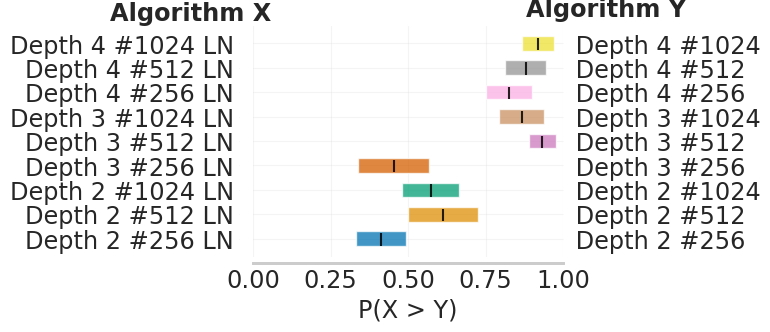

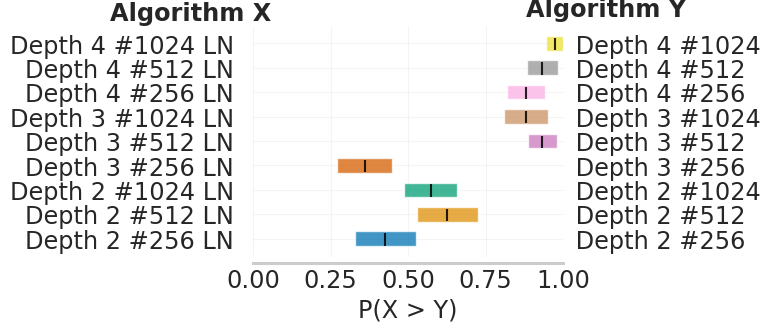

In [27]:
for metric in metrics_:
    metric_label = metric_to_metric_label_dict[metric]
    data = aggregate_data_from_wandb(
        runs, metric, exp_names, exp_names_mapping, env_title_mapping, take_x_seeds, single_env
    )

    # Smoothing
    for key, item in data.items():
        data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item)

    data_flattened = {key: np.mean(elem[:, :, -10:], axis=-1) for key, elem in data.items()}

    algorithm_pairs = {
        f"Depth {depth} #{n_neurons} LN, Depth {depth} #{n_neurons}": (
            data_flattened[f"Depth {depth} #{n_neurons} LN"],
            data_flattened[f"Depth {depth} #{n_neurons}"],
        )
        for depth in [2, 3, 4]
        for n_neurons in [256, 512, 1024]
    }

    average_probabilities, average_prob_cis = rly.get_interval_estimates(
        algorithm_pairs, metrics.probability_of_improvement, reps=500
    )
    
    # Change to se
    if use_se:
        for key, elem in average_probabilities.items():
            se = (average_prob_cis[key][1]-average_prob_cis[key][0])/2/1.96 
            average_prob_cis[key] = np.concatenate(((elem-se)[None, :], (elem+se)[None,:]), axis=0)

    ax = plot_utils.plot_probability_of_improvement(
        average_probabilities,
        average_prob_cis,
    )

    ax.set_xlim((0, 1))
    plt.savefig(os.path.join(figures_path, f"{metric_label.replace(' ', '_')}_layer_norm.pdf"), bbox_inches="tight")